### Initial Summary Graphics

### 3 Material Properties
Summarize the material properties of 3 materials using their parametric representations.

<>:181: SyntaxWarning: invalid escape sequence '\%'
<>:181: SyntaxWarning: invalid escape sequence '\%'
C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_145368\449385881.py:181: SyntaxWarning: invalid escape sequence '\%'
  label = r'' + material_name.replace('%','\%')


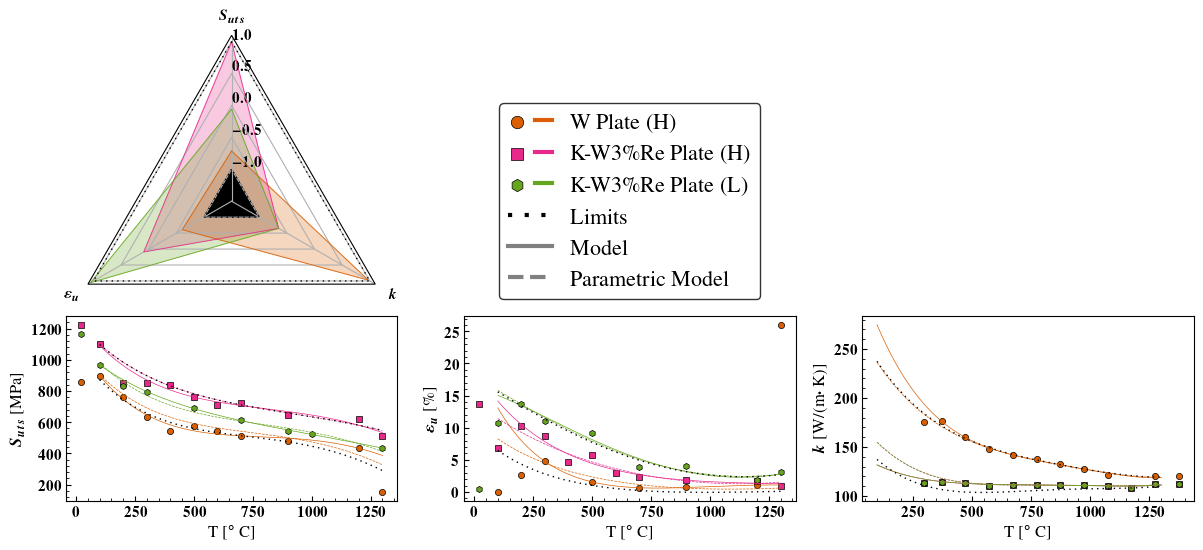

In [1]:
from matplotlib import pyplot as plt    
from common_util import make_radar_plot, ParamterizedLinearModel, NogamiDataCollection,setup_axis_default
import pickle
from typing import Tuple
import numpy as np  
import warnings
from matplotlib import rc
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from functools import cache

warnings.filterwarnings("ignore")
rc('font',**{'family':'serif','serif':['Times'],'weight': 'bold'})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

@cache
def get_opt_parameter(material_name: str, 
                      material_property: str,
                      xlim: Tuple = (500,1300)):

    """
    given a material, find the parameter "gamma" which optmially 
    represents the material property in the given temperature range
    in an L2 sense.
    """
    try:
        with open(f'.model/{material_name}_{material_property}.pkl','rb') as f:
            material_model = pickle.load(f)  
        
        with open(f'.model/{material_property}_parametric.pkl','rb') as f:
            parametric_model = pickle.load(f)
    except FileNotFoundError as fnfe:
        raise FileNotFoundError(f"Model for {material_name} not found: {str(fnfe)}")

    gamma = parametric_model.find_gamma(material_model.predict,xlim)
    return gamma

@cache
def get_parameter_representation(material_name: str,
                                 xlim: Tuple = (500,1300)):

    """
    get the optimal parametric representation of the material
    from model files
    """
    params = []
    param_names = ['uts','ue','k']
    for param_name in param_names:
        params.append(get_opt_parameter(material_name,param_name,xlim = xlim))
    
    return params

class ParametricMaterialPlot:

    """
    A parametric material property plot. This plot consists of 
    temperature dependent material properties, showing the parametric variation
    as well as a summary plot showing the parametric representation of each material,
    which is a "radar" or "spider" plot.

    This will have to be extended in the future to include more material properties
    which will have to be approached on a case by case basis as the complexity of the
    figure is somewhat difficult to generalize.
    """

    labels = [r'$S_{uts}$',r'$\varepsilon_u$',r'$k$']
    ax_labels = [r'$S_{uts}$ [MPa]',r'$\varepsilon_u$ [\%]',r'$k$ [W/(m$\cdot$ K)]']
    param_names = ['uts','ue','k']

    def __init__(self,figsize = (6,6),
                 fontsize = 12,
                 labelsize = 11):
        make_radar_plot(3,frame = 'polygon')
        self.fig = plt.figure(figsize = figsize) 
        self.axes = self.fig.subplot_mosaic(
            """
            AE.
            BCD
            """,
            per_subplot_kw= {'A': dict(projection = 'radar')},
            height_ratios= [2,1]
        )

        self.fig.subplots_adjust(hspace = -0.25,top = 0.98,right = 0.99,left = 0.05,bottom = 0.1)
        self.data = NogamiDataCollection()
        self.axes = [ax for ax in self.axes.values()]
        self.setup_property_plots(fontsize = fontsize,labelsize = labelsize)
        self.setup_radar_plot(fontsize = fontsize,labelsize = labelsize)
        self.setup_legend_axis()
        self._legend_items = {}

    def setup_property_plots(self,fontsize = 12,labelsize = 11):
        """ 
        setup the property plots for the material properties
        """
        for ax,label in zip(self.axes[2:],self.ax_labels):
            setup_axis_default(ax,labelsize = labelsize)
            ax.set_xlabel(r'T [$^\circ$ C]',fontsize = fontsize)
            ax.set_ylabel(label,fontsize = fontsize)

    def setup_radar_plot(self,fontsize = 12,labelsize = 11):
        """ 
        setup the radar plots for the parametric material property summary
        """
        self.theta = make_radar_plot(3,frame = 'polygon')
        self.axes[0].set_varlabels(self.labels,fontsize = fontsize)
        self.axes[0].tick_params('both',labelsize = labelsize)

    def setup_legend_axis(self):
        self.axes[1].axis('off')

    def legend(self,fontsize = 12):
        """
        add the legend to the empty axis
        """
        model_patch = Line2D([],[],color = 'grey',lw = 3,label = 'Model')
        parametric_patch = Line2D([],[],color = 'grey',lw = 3,ls = '--',label = 'Parametric Model')

        legend  = self.axes[1].legend(list(self._legend_items.values()) + [model_patch,parametric_patch],
                            list(self._legend_items.keys()) + ['Model','Parametric Model'],
                            handler_map = {tuple: HandlerTuple(ndivide=None)},
                            fontsize =fontsize,
                            loc = 'center',
                            markerscale = 2.)
        
        legend.get_frame().set_edgecolor('k')


    def plot_lims(self,*args,
                  xlim: Tuple = (100,1300),
                  label_lw = 3, 
                  **kwargs):
        """ 
        plot the "limits" i.e. the minimum and maximum values of the parametric representation
        both on the material property plots and the summary plot
        """
        xplot = np.linspace(xlim[0],xlim[1],1000)[:,np.newaxis]
        for ax,pname in zip(self.axes[2:],self.param_names):
            with open(f'.model/{pname}_parametric.pkl','rb') as f:
                model = pickle.load(f)
            for p_rep in [-1,1]:
                ax.plot(xplot,model(xplot,p_rep),**kwargs)

        for bound in [[-1,-1,-1],[1,1,1]]:
            self.axes[0].plot(self.theta,bound,**kwargs)
        
        self.axes[0].fill(self.theta,[-1,-1,-1],color = 'k',alpha = 1.)

        if 'lw' in kwargs:
            kwargs.pop('lw')
        if 'linewidth'  in kwargs:
            kwargs.pop('linewidth')
        
        kwargs['lw'] = label_lw

        self._legend_items['Limits'] = Line2D([],[],**kwargs,label = 'Limits')


    def plot_material(self,material_name: str,
                            xlim: Tuple = (100,1300),
                            marker = None,
                            s = 20,
                            color = None,
                            alpha = 0.1875,
                            label_lw = 3):
        """ 
        plot the temperature dependent 
        material properties and the parametric representation of the material
        on the radar plot
        """
        
        xplot = np.linspace(xlim[0],xlim[1],1000)[:,np.newaxis]
        p_rep = get_parameter_representation(material_name) 
        for ax,dat,gamma,i in zip(self.axes[2:],self.data[material_name],p_rep, range(len(p_rep))):
            sp = ax.scatter(dat[0],dat[1],color = color,s = s,marker = marker,edgecolor = 'k',lw = 0.5)
            
            with open(f'.model/{material_name}_{self.param_names[i]}.pkl','rb') as f:
                model = pickle.load(f)
            
            label = r'' + material_name.replace('%','\%')
            mlp,  = ax.plot(xplot,model.predict(xplot),color = color,ls = '-',lw = 0.5)
            mlp = Line2D([],[],color = color,lw = label_lw,label = label)

            with open(f'.model/{self.param_names[i]}_parametric.pkl','rb') as f:
                model = pickle.load(f)
            
            ax.plot(xplot,model(xplot,gamma),color = color,ls = '--',lw = 0.5)

            self._legend_items[label] = (sp,mlp)
        
        self.axes[0].plot(self.theta,p_rep,
                            lw = 0.5,color = color)
        self.axes[0].fill(self.theta,p_rep,alpha = alpha,color = color)

alloy_names = ['W Plate (H)','K-W3%Re Plate (H)','K-W3%Re Plate (L)']
markers = ['o','s','h']
colors = plt.get_cmap('Dark2')(np.arange(0.2,0.8,0.2))
property_plot = ParametricMaterialPlot(figsize = (12,5.5))
for alloy,color,marker in zip(alloy_names,colors,markers):
    property_plot.plot_material(alloy,marker = marker,color = color,s = 20,alpha = 0.25)

property_plot.plot_lims(color = 'k',lw = 1.,ls = (0,(1,3)))
property_plot.axes[0].set_rgrids([-1,-0.5,0.,0.5,1.],angle = 0)
property_plot.legend(fontsize = 16)
property_plot.axes[0].set_ylim([-1.5,1.1])

property_plot.fig.savefig('images/parametric_material_plot.svg')

### 6 Parameters

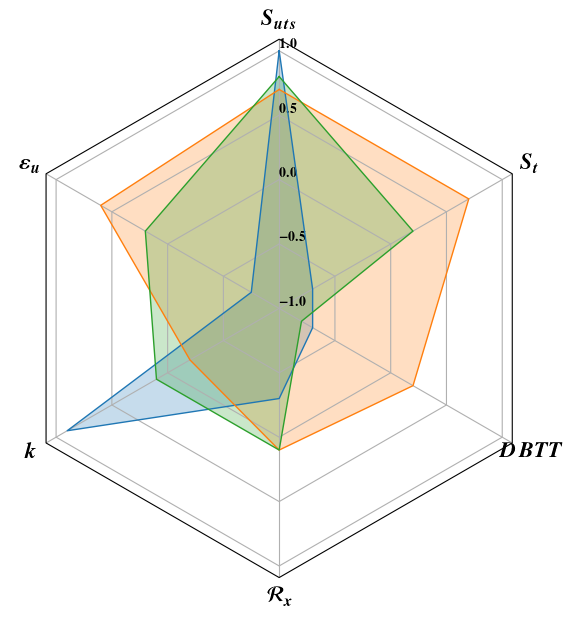

In [3]:
theta = make_radar_plot(6,frame = 'polygon')
fig,ax = plt.subplots(figsize = (6,6),subplot_kw = {'projection': 'radar'})

labels = [r'$S_{uts}$',r'$\varepsilon_u$',r'$k$',r'$\mathcal{R}_x$',r'$DBTT$',r'$S_{t}$']
alloy1 = [1.0,-0.75,0.9,-0.3,-0.7,-0.7]
alloy2 = [0.7,0.6,-0.2,0.1,0.2,0.7]
alloy3 = [0.8,0.2,0.1,0.1,-0.8,0.2]

for alloy in [alloy1,alloy2,alloy3]:
    ax.plot(theta,alloy, lw = 1.)
    ax.fill(theta,alloy,alpha = 0.25)

ax.set_varlabels(labels,fontsize = 16)
fig.tight_layout(pad = 0.1)
ax.set_rgrids([-1,-0.5,0.,0.5,1.],angle = 0)
fig.savefig('images/parametric_material_example.svg')


